In [14]:
import scipy, time, random, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score 




# required for importin modules from other directories
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from common.data_parser import *
from common.misc import *
import companies_data_preprocessor
from common.model_trainer import ModelTrainer

In [15]:
params = {
    "n_neighbors" : list(range(3,50)), 
    "weights" : ["uniform", "distance"],
    "p" : [1,2]}

#df_list = parse_companies()
#df = pd.concat(df_list)
df = parse_companies(5)
raw_data, labels = companies_data_preprocessor.preprocess(df)

In [16]:
def plot_params(data, labels, fileName="no name", title="no title"):
    # Splitting
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=1)

    modeltrainer = ModelTrainer(
        KNeighborsClassifier, 
        params, 
        x_train, y_train, x_test, y_test, 
        companies_data_preprocessor.calculate_score, 
        thread_cnt=8
        )

    modeltrainer.train()
    modeltrainer.save_result("out/knn_params.csv")
    df = modeltrainer.result

    uniform_p1 = df.loc[(df['weights'] == "uniform") & (df['p'] == 1)]
    uniform_p2 = df.loc[(df['weights'] == "uniform") & (df['p'] == 2)]
    distance_p1 = df.loc[(df['weights'] == "distance") & (df['p'] == 1)]
    distance_p1 = df.loc[(df['weights'] == "distance") & (df['p'] == 2)]

    plt.style.use('seaborn')
    plt.plot(uniform_p1["n_neighbors"], uniform_p1["score"], label="uniform, p=1")
    plt.plot(uniform_p2["n_neighbors"], uniform_p2["score"], label="uniform, p=2")
    #plt.plot(distance_p1["n_neighbors"], distance_p1["score"], label="distance, p=1")
    plt.plot(distance_p1["n_neighbors"], distance_p1["score"], label="distance, p=2")
    plt.legend()
    plt.title(title)
    plt.ylim(-1.5, 1.5)
    plt.savefig("out/" + fileName)
    plt.show()

Finished evaluation
Best parameteters found with: {'n_neighbors': 61, 'weights': 'uniform', 'p': 2}
score= 1.2662154540327129
Total evaluation time = 20.75s


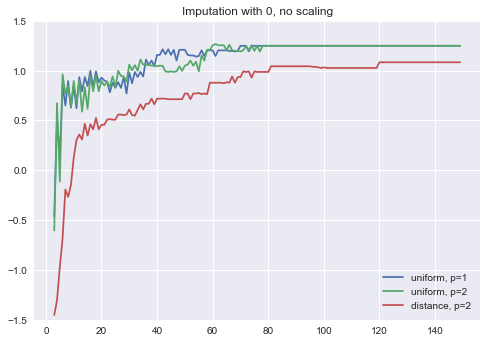

In [17]:
# Simple Imputation with 0
preprocessed_data = pd.DataFrame(SimpleImputer(missing_values=np.NaN, strategy="constant", fill_value=0).fit_transform(raw_data))

# No Scaling

plot_params(preprocessed_data, labels, fileName="companies_knn_Imputation_0_noScaling", title="Imputation with 0, no scaling")

Finished evaluation
Best parameteters found with: {'n_neighbors': 29, 'weights': 'uniform', 'p': 2}
score= 1.2718556119571347
Total evaluation time = 16.72s


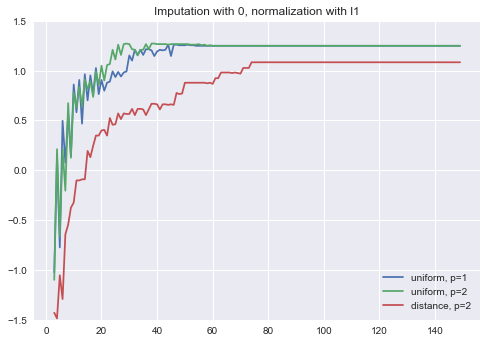

In [18]:
# Simple Imputation with 0
preprocessed_data = pd.DataFrame(SimpleImputer(missing_values=np.NaN, strategy="constant", fill_value=0).fit_transform(raw_data))

# Normalization with l1 norm
preprocessed_data = pd.DataFrame(Normalizer(norm="l1").fit_transform(preprocessed_data))

plot_params(preprocessed_data, labels, fileName="companies_knn_Imputation_0_l1Norm", title="Imputation with 0, normalization with l1")

Finished evaluation
Best parameteters found with: {'n_neighbors': 32, 'weights': 'uniform', 'p': 2}
score= 1.2662154540327129
Total evaluation time = 19.30s


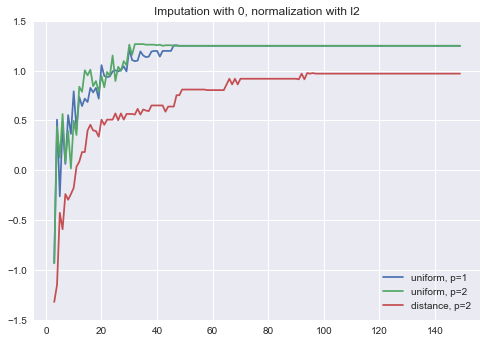

In [19]:
# Simple Imputation with 0
preprocessed_data = pd.DataFrame(SimpleImputer(missing_values=np.NaN, strategy="constant", fill_value=0).fit_transform(raw_data))

# Normalization with l2 norm
preprocessed_data = pd.DataFrame(Normalizer(norm="l2").fit_transform(preprocessed_data))

plot_params(preprocessed_data, labels, fileName="companies_knn_Imputation_0_l2Norm", title="Imputation with 0, normalization with l2")

Finished evaluation
Best parameteters found with: {'n_neighbors': 44, 'weights': 'uniform', 'p': 1}
score= 1.2718556119571347
Total evaluation time = 19.65s


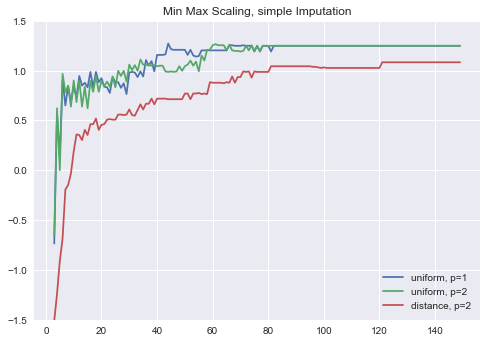

In [21]:
# KNN Imputation
imp = KNNImputer(missing_values=np.NaN, n_neighbors=10, weights="uniform")
preprocessed_data = imp.fit_transform(raw_data)

# No Scaling

plot_params(preprocessed_data, labels, fileName="companies_knn_MinMax_KNNImputation", title="Min Max Scaling, simple Imputation")

# Runtime Analysis

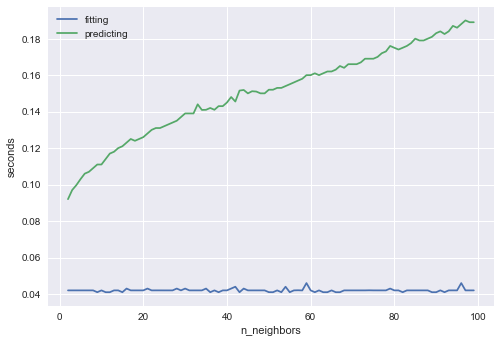

<Figure size 576x396 with 0 Axes>

In [32]:
# Simple Imputation with 0
preprocessed_data = pd.DataFrame(SimpleImputer(missing_values=np.NaN, strategy="constant", fill_value=0).fit_transform(raw_data))

# Normalization with l2 norm
preprocessed_data = pd.DataFrame(Normalizer(norm="l2").fit_transform(preprocessed_data))

x_train, x_test, y_train, y_test = train_test_split(preprocessed_data, labels, test_size=0.3, random_state=1)

fit_times = []
predict_times = []
n_vals = [n for n in range(2,100)]
for n in n_vals:
    model = KNeighborsClassifier(n_neighbors=n, weights="uniform")
    
    # Fitting
    start_time = time.time()
    model.fit(x_train, y_train)
    end_time = time.time()
    fit_times.append(end_time - start_time)

    # Predicting
    start_time = time.time()
    model.predict(x_test)
    end_time = time.time()
    predict_times.append(end_time - start_time)

plt.plot(n_vals, fit_times, label="fitting")
plt.plot(n_vals, predict_times, label="predicting")
plt.ylabel("seconds")
plt.xlabel("n_neighbors")
plt.legend()
plt.show()
plt.savefig("out/knn_runtime")